This notebook contains all post-hoc analyses to summarize the results of CFpRF, DeepRF and the hybrid approach (the combination of DeepRF and CFpRF) on the synthetic data. 

Author: Jordy Thielen (jordy.thielen@donders.ru.nl)

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, wilcoxon
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from matplotlib import rc, rcParams
rcParams['font.sans-serif'] = "Arial"
rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
rcParams['font.family'] = "sans-serif"
rcParams['pdf.fonttype'] = 42
fontsize = 14
rcParams.update(
    {'legend.fontsize': fontsize,
     'axes.labelsize': fontsize,
     'axes.titlesize': fontsize,
     'xtick.labelsize': fontsize,
     'ytick.labelsize': fontsize})


In [2]:
root = "/Users/jordythielen/2420084.01"
n_voxels = 1024
r_threshold = 0.0

alias = ("CFpRF", "DeepRF", "Hybrid", "target")
models = ("cfprf", "resnet50_chan", "resnet50_chan_cfprf", "target")
n_models = len(models)

parameters = ("delay", "sigma", "x", "y")
limits = [(-2, 2), (0, 8), (-8, 8), (-8, 8)]


In [3]:
# Extract data and put in dataframe

df = pd.DataFrame(columns=("voxel", "model", "explained variance", "ctime", 
                           "delay", "sigma", "x", "y", "edelay", "esigma", "ex", "ey"))

i = 0
for i_model, model in enumerate(models):
    
    tmp = np.load(os.path.join(root, "derivatives", model, "results_synthetic.npz"))
    t_train = tmp["t_train"]
    y_train = tmp["y_train"]
    r_valid = tmp["r_valid"]
    ctime = tmp["ctime"]
    n_voxels = ctime.size
    
    for i_voxel in range(n_voxels):
        voxel = "vox-{:02d}".format(1 + i_voxel)
                  
        delay = y_train[i_voxel, 0]
        sigma = y_train[i_voxel, 1]
        x_pos = y_train[i_voxel, 2]
        y_pos = y_train[i_voxel, 3]
                  
        df.loc[i] = [voxel, model, r_valid[i_voxel], ctime[i_voxel],
            delay, sigma, x_pos, y_pos,
            delay - t_train[i_voxel, 0], 
            sigma - t_train[i_voxel, 1], 
            x_pos - t_train[i_voxel, 2], 
            y_pos - t_train[i_voxel, 3]]
        
        i += 1
        
df = df.round(3)


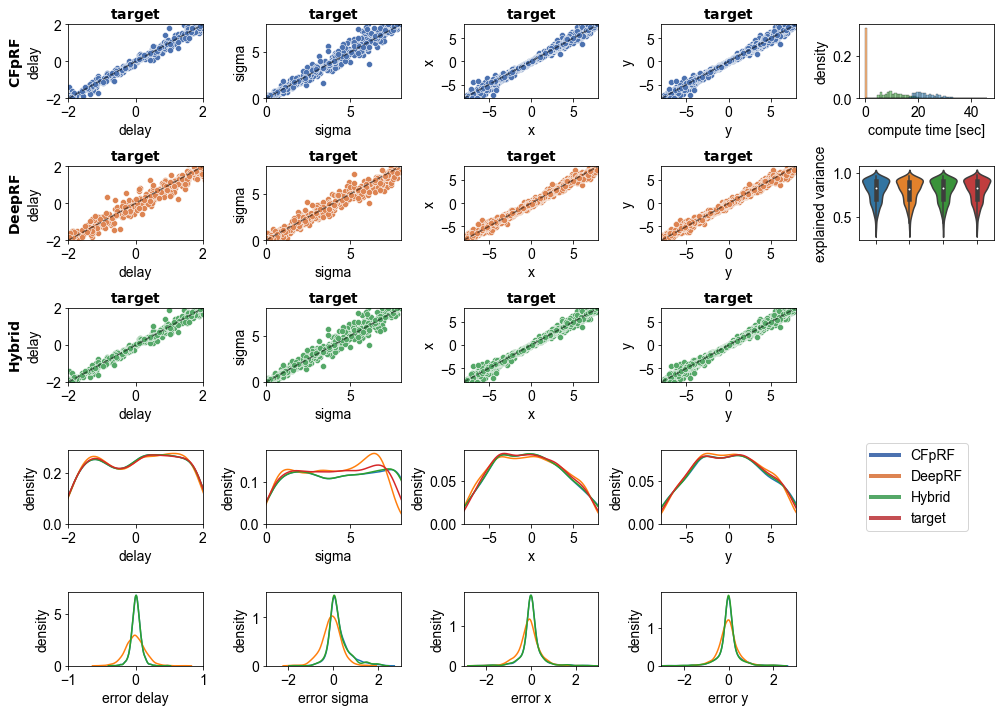

In [4]:
# Plot results against target

fig, axes = plt.subplots(5, 5, figsize=(14, 10))

colors = sns.color_palette("deep", n_models)

err_limits = ([-1, 1], [-3, 3], [-3, 3], [-3, 3])

for j, parameter in enumerate(parameters):
    axes[0,j].set_title(parameter)

for i, model in enumerate(models[:-1]):
    for j in range(len(parameters)):
        ax = axes[i,j]
        ax.plot(limits[j], limits[j], color="k", linestyle="--", alpha=0.5)
        sns.scatterplot(
            x=df[df["model"] == "target"][parameter].array, 
            y=df[df["model"] == model][parameter].array, 
            ax=ax, color=colors[i])
        ax.set_xlim(limits[j])
        ax.set_ylim(limits[j])
        ax.set_title("$\\bf{target}$")
        ax.set_xlabel(parameters[j])
        ax.set_ylabel(parameters[j])
axes[0,0].set_ylabel("$\\bf{CFpRF}$\ndelay")
axes[1,0].set_ylabel("$\\bf{DeepRF}$\ndelay")
axes[2,0].set_ylabel("$\\bf{Hybrid}$\ndelay")
    
for model in models:
    for j, param in enumerate(parameters):
        ax = axes[3,j]
        sns.kdeplot(data=df[df["model"] == model], x=param, ax=ax)
        ax.set_xlim(limits[j])
        ax.set_ylabel("density")
        ax.set_xlabel(param)

for model in models[:-1]:
    for j, param in enumerate(["edelay", "esigma", "ex", "ey"]):
        ax = axes[4,j]
        sns.kdeplot(data=df[df["model"] == model], x=param, ax=ax)
        ax.set_ylabel("density")
        ax.set_xlabel("error " + parameters[j])
        ax.set_xlim(err_limits[j])
    
ax = axes[0,4]
sns.histplot(data=df[df["model"] != "target"], x="ctime", hue="model", ax=ax, legend=False, stat="probability", bins=50)
ax.set_xlabel("compute time [sec]")
ax.set_ylabel("density")

ax = axes[1,4]
sns.violinplot(data=df, x="model", y="explained variance", ax=ax)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("explained variance")
#ax.set_xticks(np.arange(n_models))
#ax.set_xticklabels(alias, rotation=45)

axes[2,4].axis('off')
axes[3,4].axis('off')
axes[4,4].axis('off')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
axes[3,4].legend(custom_lines, alias, loc="center left")

fig.tight_layout()

plt.savefig(os.path.join(root, "derivatives", "synthetic_vs_target.pdf"), dpi=300)


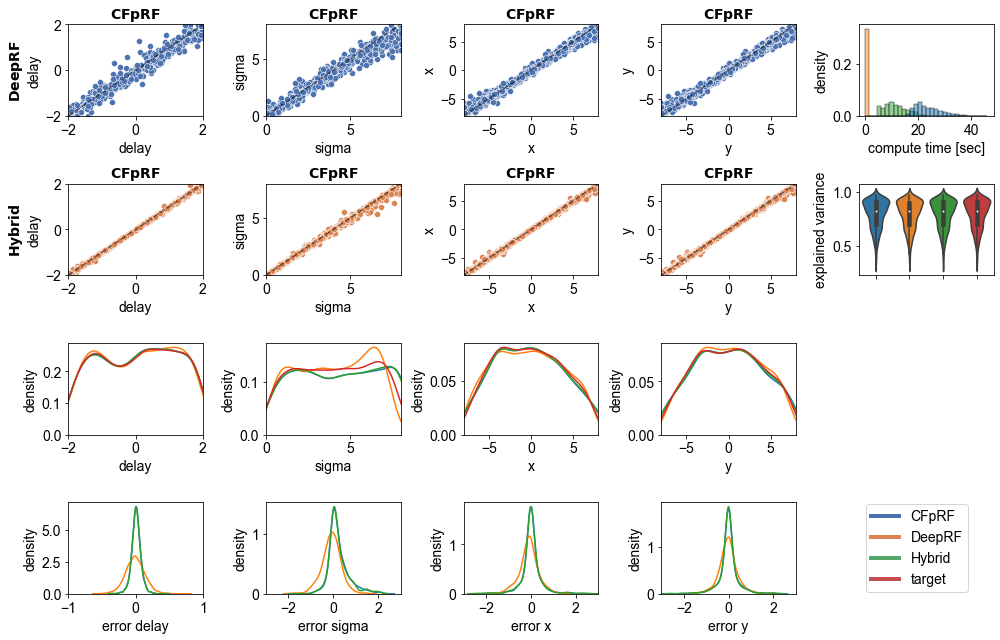

In [5]:
# Plot results against CFpRF

fig, axes = plt.subplots(4, 5, figsize=(14, 9))

colors = sns.color_palette("deep", n_models)

err_limits = ([-1, 1], [-3, 3], [-3, 3], [-3, 3])

for j, parameter in enumerate(parameters):
    axes[0,j].set_title(parameter)

for i, model in enumerate(models[1:-1]):
    for j in range(len(parameters)):
        ax = axes[i,j]
        ax.plot(limits[j], limits[j], color="k", linestyle="--", alpha=0.5)
        sns.scatterplot(
            x=df[df["model"] == "cfprf"][parameter].array, 
            y=df[df["model"] == model][parameter].array, 
            ax=ax, color=colors[i])
        ax.set_xlim(limits[j])
        ax.set_ylim(limits[j])
        ax.set_title("$\\bf{CFpRF}$")
        ax.set_xlabel(parameters[j])
        ax.set_ylabel(parameters[j])
axes[0,0].set_ylabel("$\\bf{DeepRF}$\ndelay")
axes[1,0].set_ylabel("$\\bf{Hybrid}$\ndelay")
    
for model in models:
    for j, param in enumerate(parameters):
        ax = axes[2,j]
        sns.kdeplot(data=df[df["model"] == model], x=param, ax=ax)
        ax.set_xlim(limits[j])
        ax.set_ylabel("density")
        ax.set_xlabel(param)

for model in models[:-1]:
    for j, param in enumerate(["edelay", "esigma", "ex", "ey"]):
        ax = axes[3,j]
        sns.kdeplot(data=df[df["model"] == model], x=param, ax=ax)
        ax.set_ylabel("density")
        ax.set_xlabel("error " + parameters[j])
        ax.set_xlim(err_limits[j])
    
ax = axes[0,4]
sns.histplot(data=df[df["model"] != "target"], x="ctime", hue="model", ax=ax, legend=False, stat="probability", bins=30)
ax.set_xlabel("compute time [sec]")
ax.set_ylabel("density")

ax = axes[1,4]
sns.violinplot(data=df, x="model", y="explained variance", ax=ax)
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("explained variance")
#ax.set_xticks(np.arange(n_models))
#ax.set_xticklabels(alias, rotation=45)

axes[2,4].axis('off')
axes[3,4].axis('off')
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                Line2D([0], [0], color=colors[1], lw=4),
                Line2D([0], [0], color=colors[2], lw=4),
                Line2D([0], [0], color=colors[3], lw=4)]
axes[3,4].legend(custom_lines, alias, loc="center left")

fig.tight_layout()

plt.savefig(os.path.join(root, "derivatives", "synthetic_vs_cfprf.pdf"), dpi=300)


In [6]:
# Compute time

ctime_cfprf = np.load(os.path.join(root, "derivatives", "cfprf", "results_synthetic.npz"))["ctime"].mean()
ctime_deeprf = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_synthetic.npz"))["ctime"].mean()
ctime_deeprf_cfprf = np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_synthetic.npz"))["ctime"].mean()
ctime_deeprf_gpu = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_synthetic_batch.npz"))["ctime"].mean()

print("cfprf : {:7.4f}".format(ctime_cfprf))
print("deeprf: {:7.4f} ({:5.1f})".format(ctime_deeprf, ctime_cfprf / ctime_deeprf))
print("hybrid: {:7.4f} ({:5.1f})".format(ctime_deeprf_cfprf, ctime_cfprf / ctime_deeprf_cfprf))
print("deeprf+gpu: {:7.4f} ({:5.1f})".format(ctime_deeprf_gpu, ctime_cfprf / ctime_deeprf_gpu))
    

cfprf : 23.7621
deeprf:  0.0263 (904.7)
hybrid: 11.4904 (  2.1)
deeprf+gpu:  0.0055 (4289.4)


In [7]:
# Explained variance valid

rtrn_target = np.load(os.path.join(root, "derivatives", "target", "results_synthetic.npz"))["r_train"]
rtrn_cfprf = np.load(os.path.join(root, "derivatives", "cfprf", "results_synthetic.npz"))["r_train"]
rtrn_deeprf = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_synthetic.npz"))["r_train"]
rtrn_hybrid = np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_synthetic.npz"))["r_train"]

print("mean and std")
print("target: {:6.3f} +/- {:5.3f}".format(rtrn_target.mean(), rtrn_target.std()))
print("cfprf : {:6.3f} +/- {:5.3f}".format(rtrn_cfprf.mean(), rtrn_cfprf.std()))
print("deeprf: {:6.3f} +/- {:5.3f}".format(rtrn_deeprf.mean(), rtrn_deeprf.std()))
print("hybrid: {:6.3f} +/- {:5.3f}".format(rtrn_hybrid.mean(), rtrn_hybrid.std()))

print("\ntarget versus ...")
p = wilcoxon(rtrn_target, rtrn_cfprf, zero_method="zsplit")[1]
print("target vs cfprf : {:.3f}".format(p))
p = wilcoxon(rtrn_target, rtrn_deeprf, zero_method="zsplit")[1]
print("target vs deeprf: {:.3f}".format(p))
p = wilcoxon(rtrn_target, rtrn_hybrid, zero_method="zsplit")[1]
print("target vs hybrid: {:.3f}".format(p))

print("\ncfprf versus ...")
p = wilcoxon(rtrn_cfprf, rtrn_deeprf, zero_method="zsplit")[1]
print("cfprf vs deeprf: {:.3f}".format(p))
p = wilcoxon(rtrn_cfprf, rtrn_hybrid, zero_method="zsplit")[1]
print("cfprf vs hybrid: {:.3f}".format(p))


mean and std
target:  0.794 +/- 0.133
cfprf :  0.794 +/- 0.133
deeprf:  0.791 +/- 0.132
hybrid:  0.794 +/- 0.133

target versus ...
target vs cfprf : 0.000
target vs deeprf: 0.000
target vs hybrid: 0.000

cfprf versus ...
cfprf vs deeprf: 0.000
cfprf vs hybrid: 0.056


In [8]:
# Explained variance valid

rval_target = np.load(os.path.join(root, "derivatives", "target", "results_synthetic.npz"))["r_valid"]
rval_cfprf = np.load(os.path.join(root, "derivatives", "cfprf", "results_synthetic.npz"))["r_valid"]
rval_deeprf = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_synthetic.npz"))["r_valid"]
rval_hybrid = np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_synthetic.npz"))["r_valid"]

print("mean and std")
print("target: {:6.3f} +/- {:5.3f}".format(rval_target.mean(), rval_target.std()))
print("cfprf : {:6.3f} +/- {:5.3f}".format(rval_cfprf.mean(), rval_cfprf.std()))
print("deeprf: {:6.3f} +/- {:5.3f}".format(rval_deeprf.mean(), rval_deeprf.std()))
print("hybrid: {:6.3f} +/- {:5.3f}".format(rval_hybrid.mean(), rval_hybrid.std()))

print("\ntarget versus ...")
p = wilcoxon(rval_target, rval_cfprf, zero_method="zsplit")[1]
print("target vs cfprf : {:.3f}".format(p))
p = wilcoxon(rval_target, rval_deeprf, zero_method="zsplit")[1]
print("target vs deeprf: {:.3f}".format(p))
p = wilcoxon(rval_target, rval_hybrid, zero_method="zsplit")[1]
print("target vs hybrid: {:.3f}".format(p))

print("\ncfprf versus ...")
p = wilcoxon(rval_cfprf, rval_deeprf, zero_method="zsplit")[1]
print("cfprf vs deeprf: {:.3f}".format(p))
p = wilcoxon(rval_cfprf, rval_hybrid, zero_method="zsplit")[1]
print("cfprf vs hybrid: {:.3f}".format(p))


mean and std
target:  0.796 +/- 0.131
cfprf :  0.794 +/- 0.131
deeprf:  0.791 +/- 0.131
hybrid:  0.794 +/- 0.131

target versus ...
target vs cfprf : 0.000
target vs deeprf: 0.000
target vs hybrid: 0.000

cfprf versus ...
cfprf vs deeprf: 0.000
cfprf vs hybrid: 0.613


In [9]:
# Model training
tmp = torch.load(os.path.join(root, "derivatives", "resnet50_chan", "best_model.pt"), "cpu")
print("The model was trained in {} epochs and {:.3f} seconds ({:.3f} minutes or {:.3f} hours)".format(
    tmp["epoch"], tmp["ctime"], tmp["ctime"]/60, tmp["ctime"]/60/60))

tmp = torch.load(os.path.join(root, "derivatives", "resnet50_chan", "model.pt"), "cpu")
print("The model was trained in {} epochs and {:.3f} seconds ({:.3f} minutes or {:.3f} hours)".format(
    tmp["epoch"], tmp["ctime"], tmp["ctime"]/60, tmp["ctime"]/60/60))


The model was trained in 154 epochs and 14563.082 seconds (242.718 minutes or 4.045 hours)
The model was trained in 199 epochs and 18760.471 seconds (312.675 minutes or 5.211 hours)


In [10]:
# Correlation parameters

y_target = np.load(os.path.join(root, "derivatives", "target", "results_synthetic.npz"))["y_train"]
y_cfprf = np.load(os.path.join(root, "derivatives", "cfprf", "results_synthetic.npz"))["y_train"]
y_deeprf = np.load(os.path.join(root, "derivatives", "resnet50_chan", "results_synthetic.npz"))["y_train"]
y_hybrid = np.load(os.path.join(root, "derivatives", "resnet50_chan_cfprf", "results_synthetic.npz"))["y_train"]

print("CFpRF versus target")
for i_param, param in enumerate(parameters):
    r = pearsonr(y_cfprf[:, i_param], y_target[:, i_param])[0]
    print("\taverage r {}: {:.3f}".format(param, r))
    
print("DeepRF versus target")
for i_param, param in enumerate(parameters):
    r = pearsonr(y_deeprf[:, i_param], y_target[:, i_param])[0]
    print("\taverage r {}: {:.3f}".format(param, r))
    
print("Hybrid versus target")
for i_param, param in enumerate(parameters):
    r = pearsonr(y_hybrid[:, i_param], y_target[:, i_param])[0]
    print("\taverage r {}: {:.3f}".format(param, r))

print("CFpRF versus DeepRF")
for i_param, param in enumerate(parameters):
    r = pearsonr(y_cfprf[:, i_param], y_deeprf[:, i_param])[0]
    print("\taverage r {}: {:.3f}".format(param, r))
    
print("CFpRF versus Hybrid")
for i_param, param in enumerate(parameters):
    r = pearsonr(y_cfprf[:, i_param], y_hybrid[:, i_param])[0]
    print("\taverage r {}: {:.3f}".format(param, r))
    

CFpRF versus target
	average r delay: 0.998
	average r sigma: 0.983
	average r x: 0.994
	average r y: 0.995
DeepRF versus target
	average r delay: 0.992
	average r sigma: 0.982
	average r x: 0.994
	average r y: 0.994
Hybrid versus target
	average r delay: 0.998
	average r sigma: 0.983
	average r x: 0.994
	average r y: 0.995
CFpRF versus DeepRF
	average r delay: 0.994
	average r sigma: 0.984
	average r x: 0.993
	average r y: 0.994
CFpRF versus Hybrid
	average r delay: 1.000
	average r sigma: 0.999
	average r x: 0.999
	average r y: 0.999
